<a href="https://colab.research.google.com/github/LEEINSEO-0118/HD_AI_Challenge/blob/main/HD_AI_Challegne_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리, 데이터 불러오기

In [1]:
# 설치에 필요한 라이브러리들이 있다면 모두 적어둡니다. anaconda에 기본적으로 설치되지 않은 라이브러리들을 적어두세요.
!pip install lightgbm optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.4 MB/s eta 0:00:00


In [2]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 모델들, 성능 평가
# (저는 일반적으로 정형데이터로 머신러닝 분석할 때는 이 2개 모델은 그냥 돌려봅니다. 특히 RF가 테스트하기 좋습니다.)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor

# 상관관계 분석, VIF : 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna

from tqdm import tqdm

In [3]:
# flag setting
feature_reducing = False

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [99]:
# 데이터를 불러옵니다.
file_path = '/content/drive/MyDrive/ai부트캠프/Machine_Learning/DATA/HD_challenge/'
train = pd.read_csv(file_path + 'train.csv')
test = pd.read_csv(file_path + 'test.csv')
print(train.shape, test.shape)

(391939, 23) (220491, 22)


In [100]:
train = train.drop(columns = 'SAMPLE_ID')
test = test.drop(columns = 'SAMPLE_ID')

#EDA

- 데이터에서 찾아야 하는 기초적인 내용들을 확인합니다.


- class imbalance, target distribution, outlier, correlation을 확인합니다.

#### 결측치 탐색

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              391939 non-null  object 
 1   ARI_PO              391939 non-null  object 
 2   SHIP_TYPE_CATEGORY  391939 non-null  object 
 3   DIST                391939 non-null  float64
 4   ATA                 391939 non-null  object 
 5   ID                  391939 non-null  object 
 6   BREADTH             391938 non-null  float64
 7   BUILT               391939 non-null  int64  
 8   DEADWEIGHT          391939 non-null  int64  
 9   DEPTH               391938 non-null  float64
 10  DRAUGHT             391938 non-null  float64
 11  GT                  391939 non-null  int64  
 12  LENGTH              391938 non-null  float64
 13  SHIPMANAGER         391939 non-null  object 
 14  FLAG                391939 non-null  object 
 15  U_WIND              228251 non-nul

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220491 entries, 0 to 220490
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              220491 non-null  object 
 1   ARI_PO              220491 non-null  object 
 2   SHIP_TYPE_CATEGORY  220491 non-null  object 
 3   DIST                220491 non-null  float64
 4   ATA                 220491 non-null  object 
 5   ID                  220491 non-null  object 
 6   BREADTH             220491 non-null  float64
 7   BUILT               220491 non-null  int64  
 8   DEADWEIGHT          220491 non-null  int64  
 9   DEPTH               220491 non-null  float64
 10  DRAUGHT             220491 non-null  float64
 11  GT                  220491 non-null  int64  
 12  LENGTH              220491 non-null  float64
 13  SHIPMANAGER         220491 non-null  object 
 14  FLAG                220491 non-null  object 
 15  U_WIND              128766 non-nul

결측치 탐색 결과 : U_WIND, V_WIND, AIR_TEMPERATURE, BN의 결측치가 많음
나머지 결측은 drop할 예정

그래프를 볼 때 두 가지를 보자.
* 데이터가 상대적으로 매우 적은지 -> 매우 적은 경우 범주를 합치는 등의 변환이 필요하다.
* 데이터의 분포가 극단으로 치우지는가 -> log 변환등 방법을 통해 정규화 해주어야 한다.



In [10]:
# numeric_feature = ['DIST', 'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH',
#                    'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'ATA_LT', 'PORT_SIZE', 'BN']
# ordinal_feature = ['year', 'month', 'day', 'hour', 'minute', 'weekday']
# categorical_feature = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID','SHIPMANAGER', 'FLAG']
# target = 'CI_HOUR'

#### 수치형 변수 탐색

100%|██████████| 15/15 [00:00<00:00, 17.52it/s]


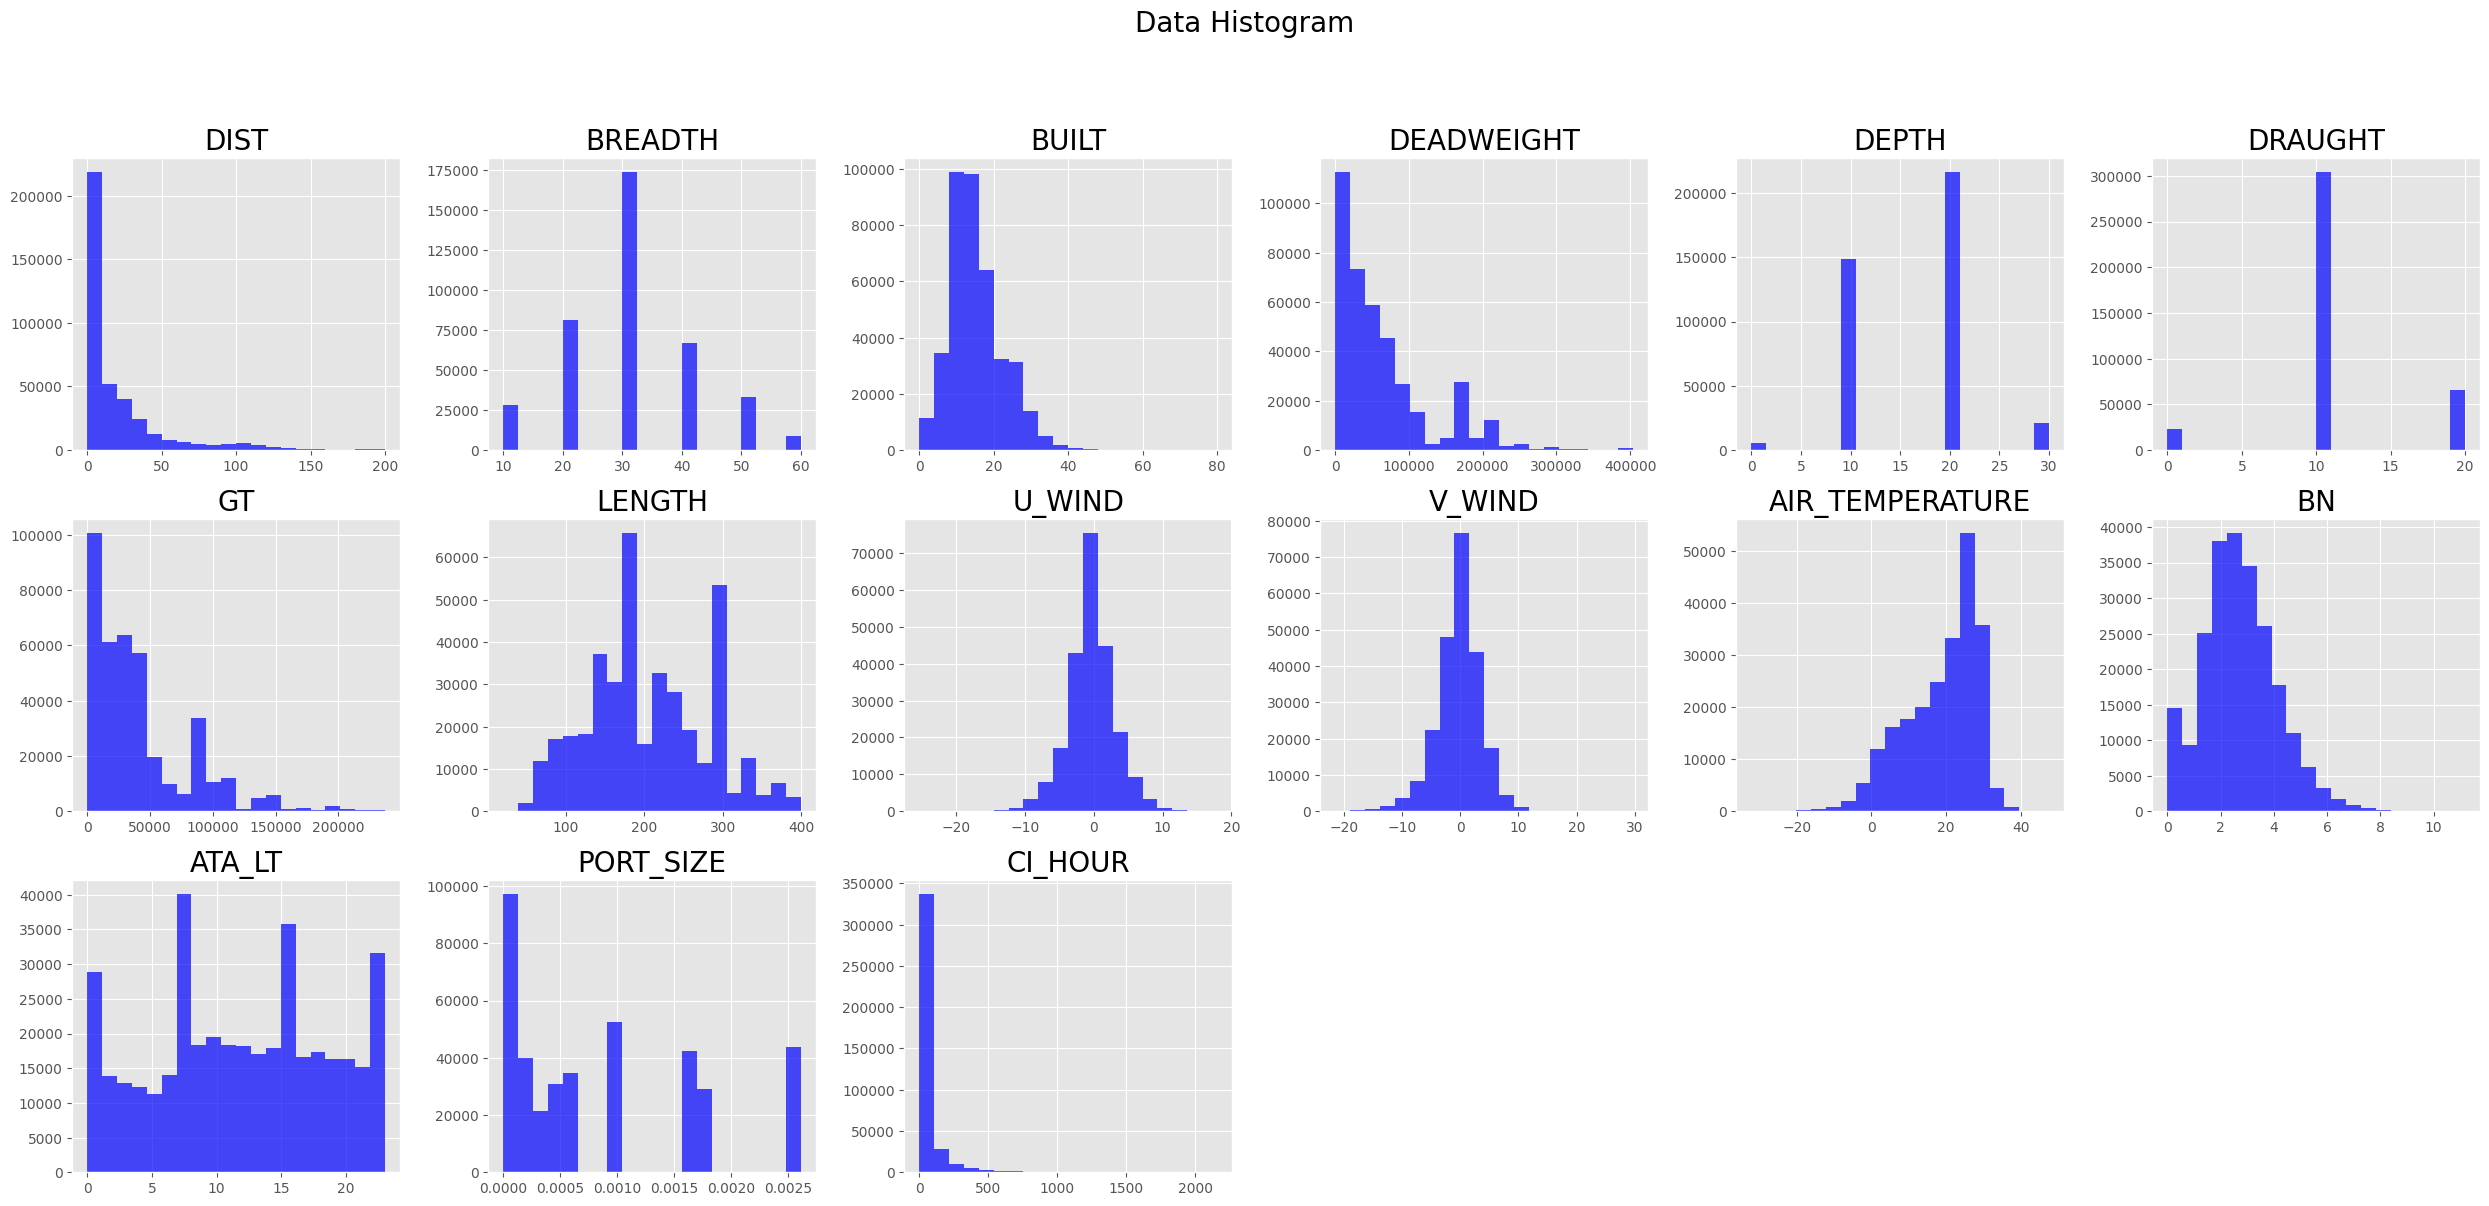

In [101]:
plt.style.use('ggplot')

numeric_feature = train.columns[(train.dtypes == 'int64')|(train.dtypes == 'float')]
num_data = train[numeric_feature]

# 히스토그램을 사용하여 데이터 분포 살펴보기
plt.figure(figsize=(25,20))
plt.suptitle('Data Histogram', fontsize=20)

cols = num_data.columns
for i in tqdm(range(len(cols))):
    plt.subplot(5, 6, i+1)
    plt.title(cols[i], fontsize = 20)
    plt.hist(num_data[cols[i]], bins=20, color='b', alpha=0.7)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('Hist.png')

100%|██████████| 15/15 [00:00<00:00, 16.45it/s]


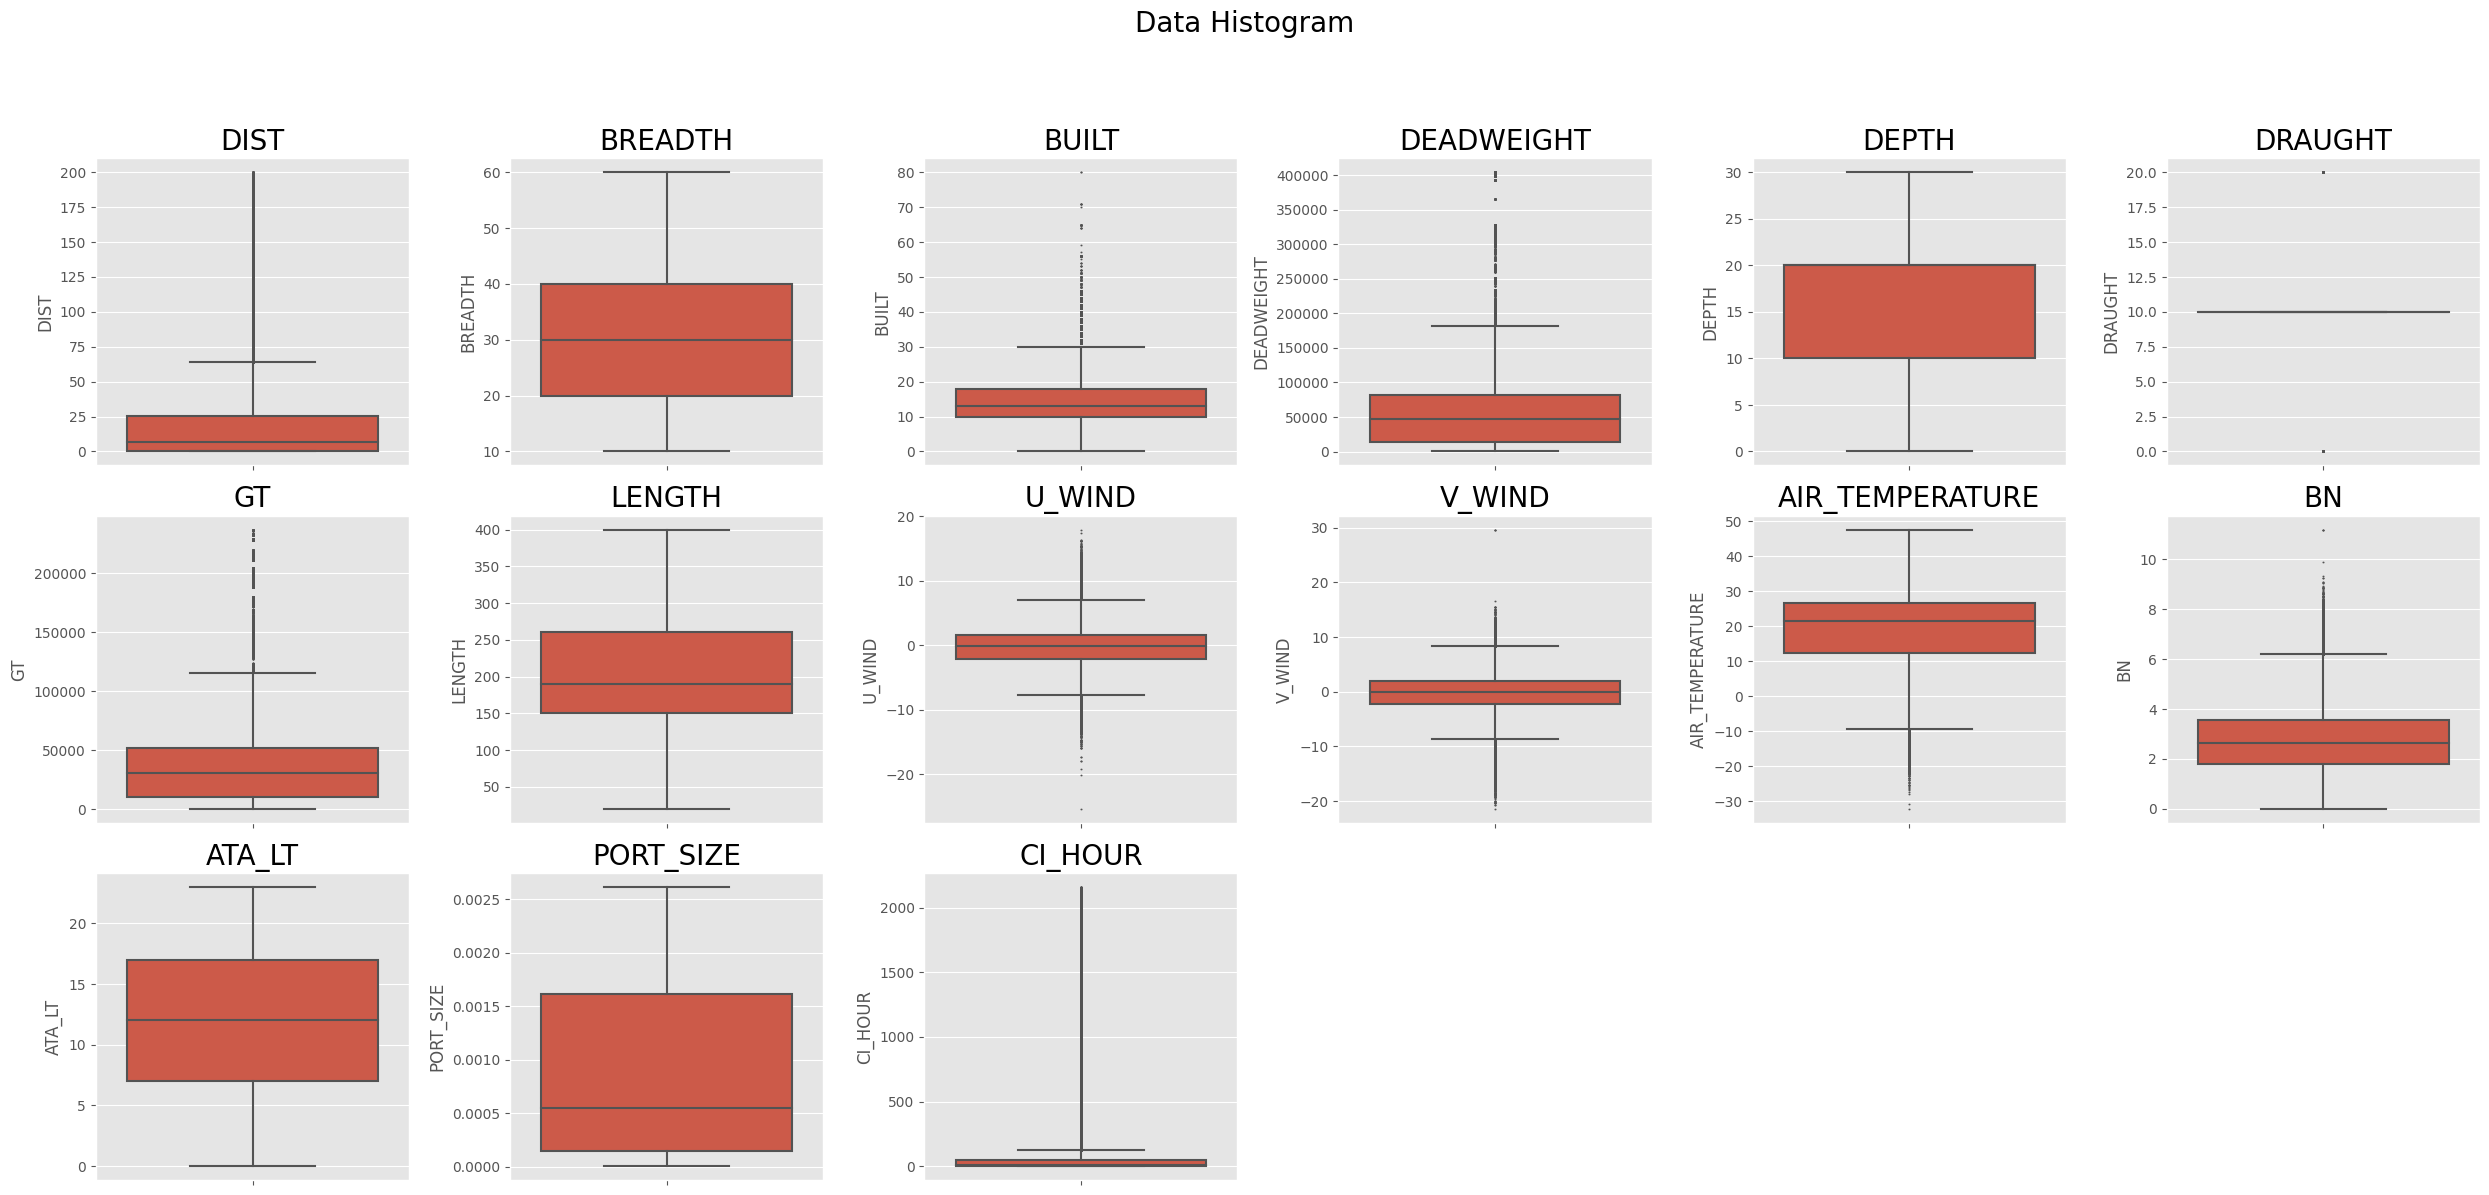

In [103]:
# Boxplot 사용하여 데이터 분포 살펴보기
plt.figure(figsize=(25,20))
plt.suptitle('Data Histogram', fontsize=20)

cols = num_data.columns
for i in tqdm(range(len(cols))):
    plt.subplot(5, 6, i+1)
    plt.title(cols[i], fontsize = 20)
    sns.boxplot(data = train, y = cols[i], fliersize = 0.5)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('box.png')

In [13]:
# 왜도 수치
# for xstr in numeric_feature:
#     print(xstr, "Skew :", train[xstr].skew())

DIST Skew : 2.482925677083371
BREADTH Skew : 0.3489412153900746
BUILT Skew : 0.8363188995692173
DEADWEIGHT Skew : 1.5715726049888608
DEPTH Skew : -0.02986966383060782
DRAUGHT Skew : 0.3954190416593463
GT Skew : 1.4989979859353066
LENGTH Skew : 0.20309039666140133
U_WIND Skew : -0.031120663515962765
V_WIND Skew : -0.5132270395010409
AIR_TEMPERATURE Skew : -0.7825021482011094
BN Skew : 0.35139810839466007
ATA_LT Skew : -0.06710644136238052
PORT_SIZE Skew : 0.8653269800670685
CI_HOUR Skew : 6.162589635646874



수치 데이터 분포 탐색 결과 : DIST, DEADWEIGHT, GT 왜도가 심하다.


#### 범주형 변수 탐색

In [8]:
# datetime 컬럼 처리
train.ATA = pd.to_datetime(train['ATA'])
test.ATA = pd.to_datetime(test['ATA'])

# datetime 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

1th col, year
2th col, month
3th col, day
4th col, hour
5th col, minute
6th col, weekday


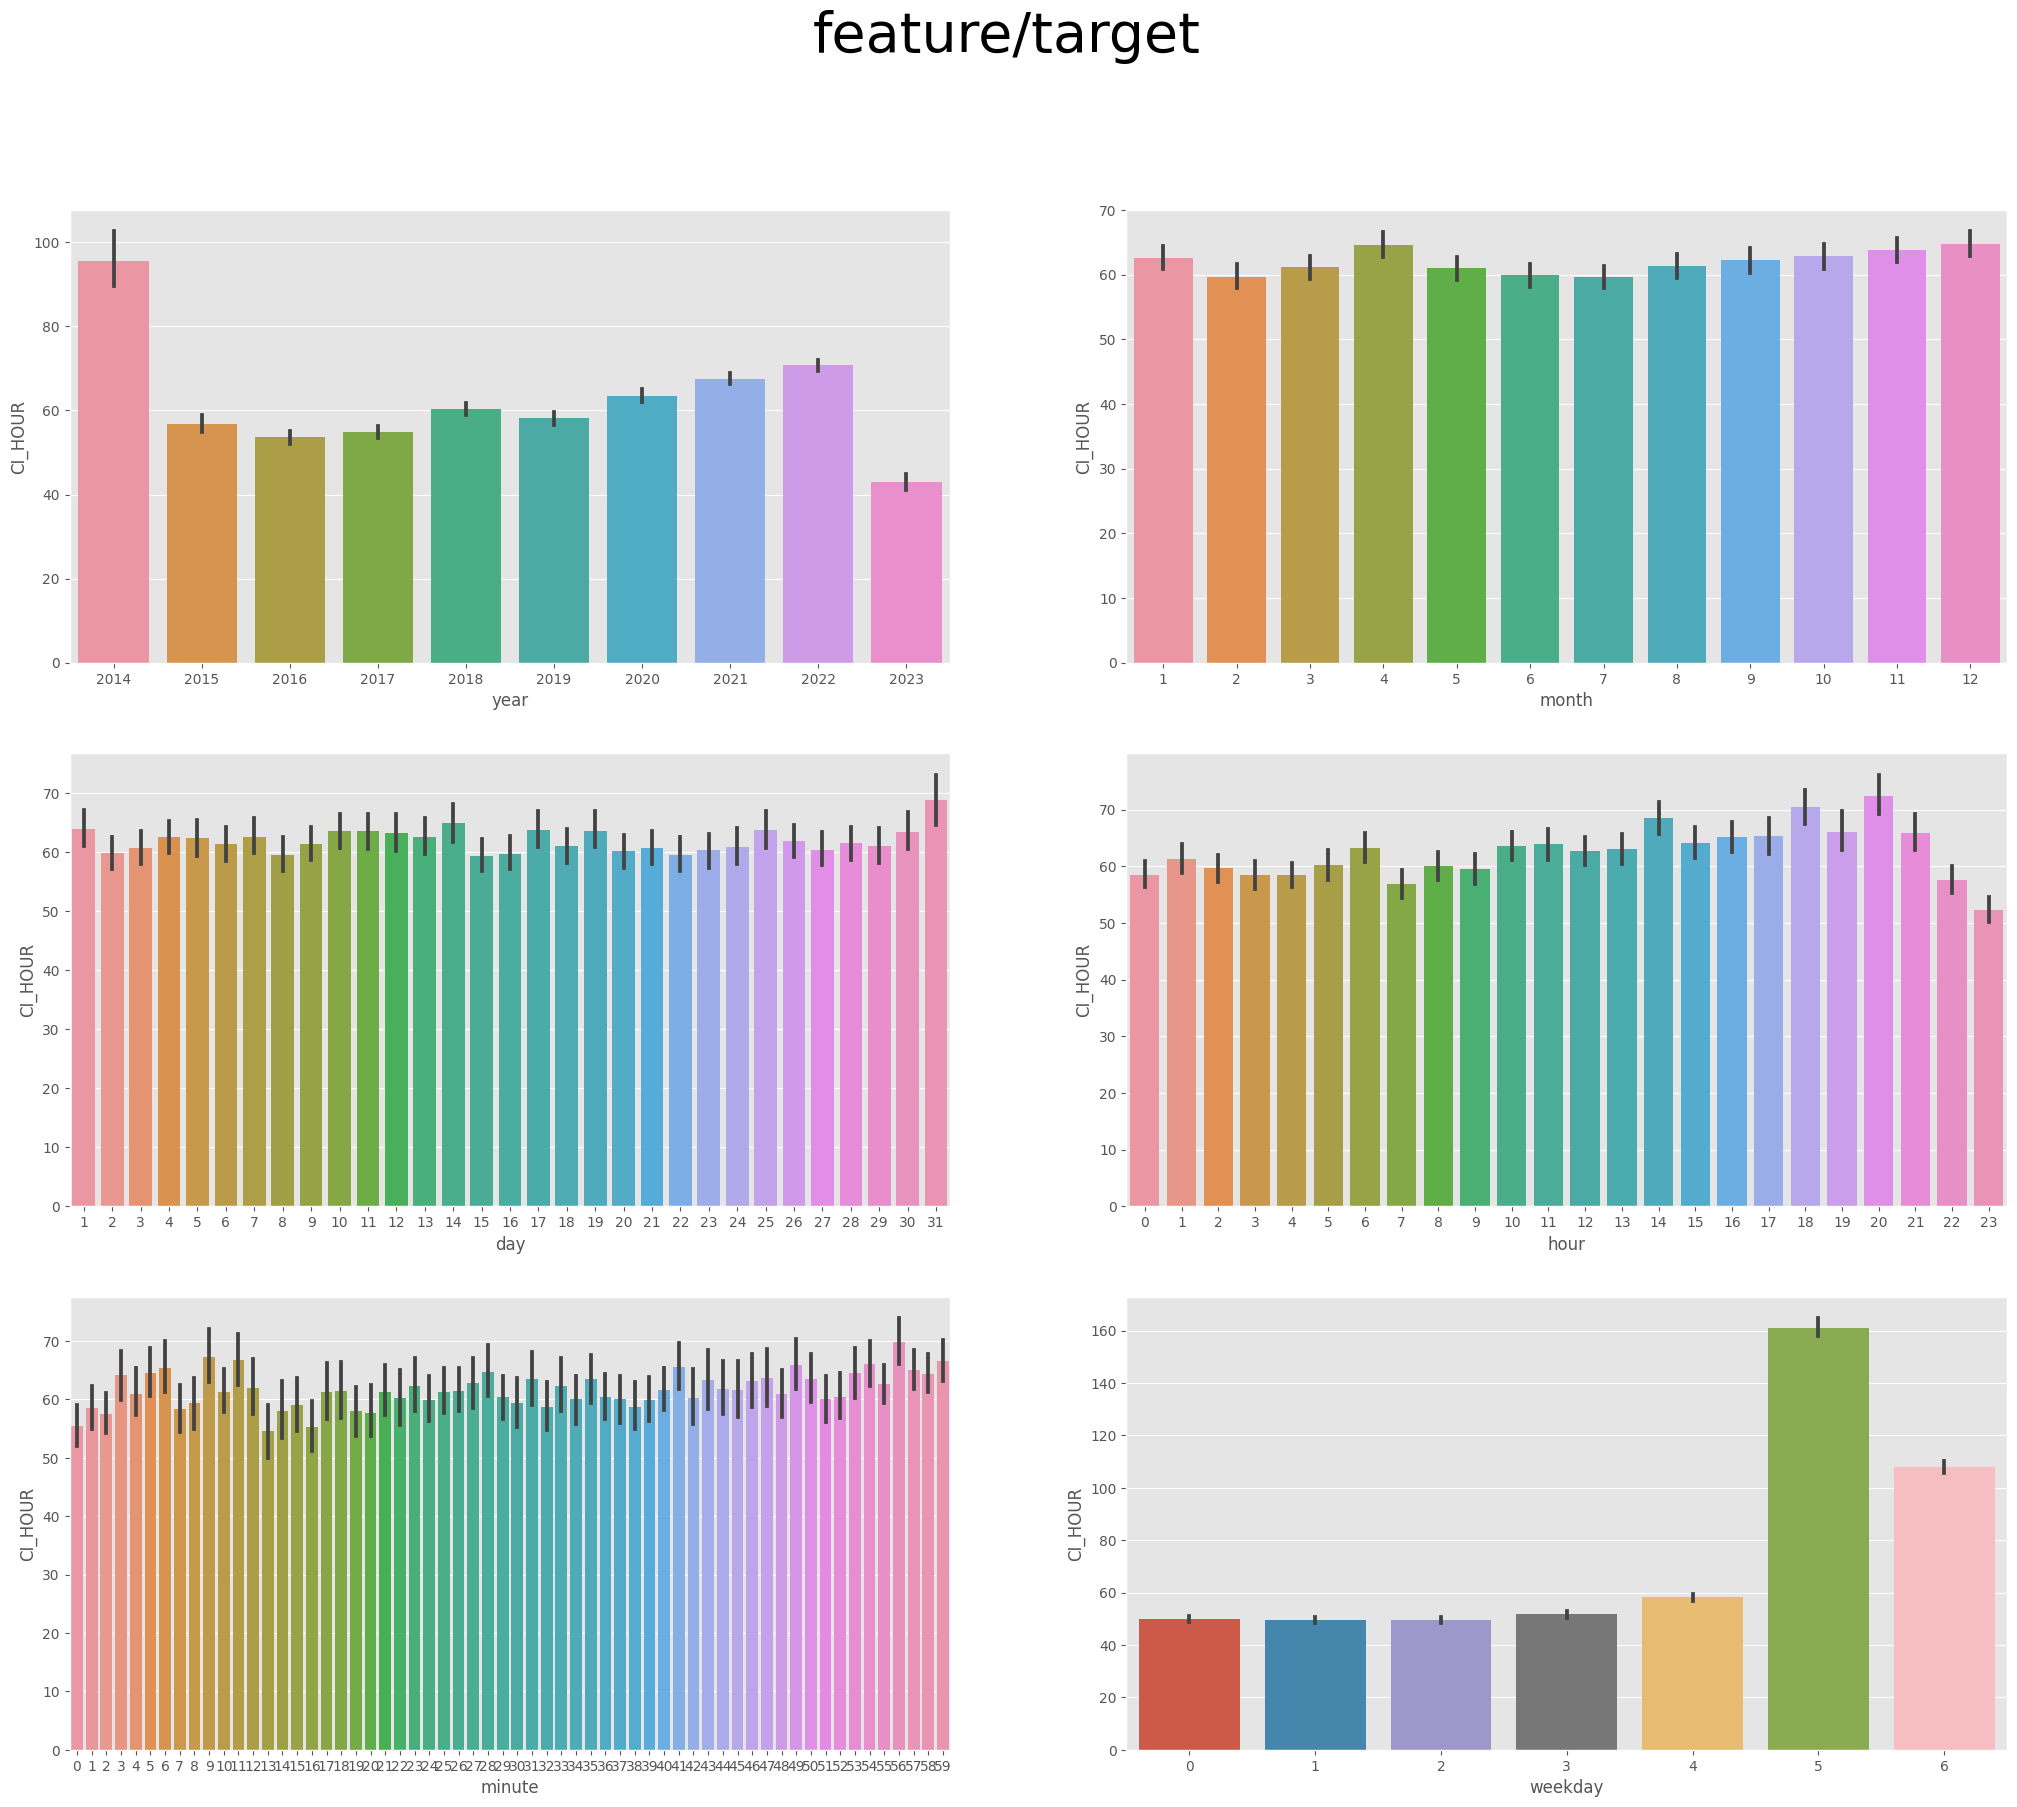

In [15]:
plt.figure(figsize=(25,20))
plt.suptitle('feature/target', fontsize=40)

i=0
for col_name in ordinal_feature:
    print(f'{i + 1}th col, {col_name}')
    plt.subplot(3, 2, i + 1)
    i += 1
    sns.barplot(data = train, x = col_name, y = 'CI_HOUR')
plt.savefig('date-feature.png')

1th col
2th col
3th col
4th col


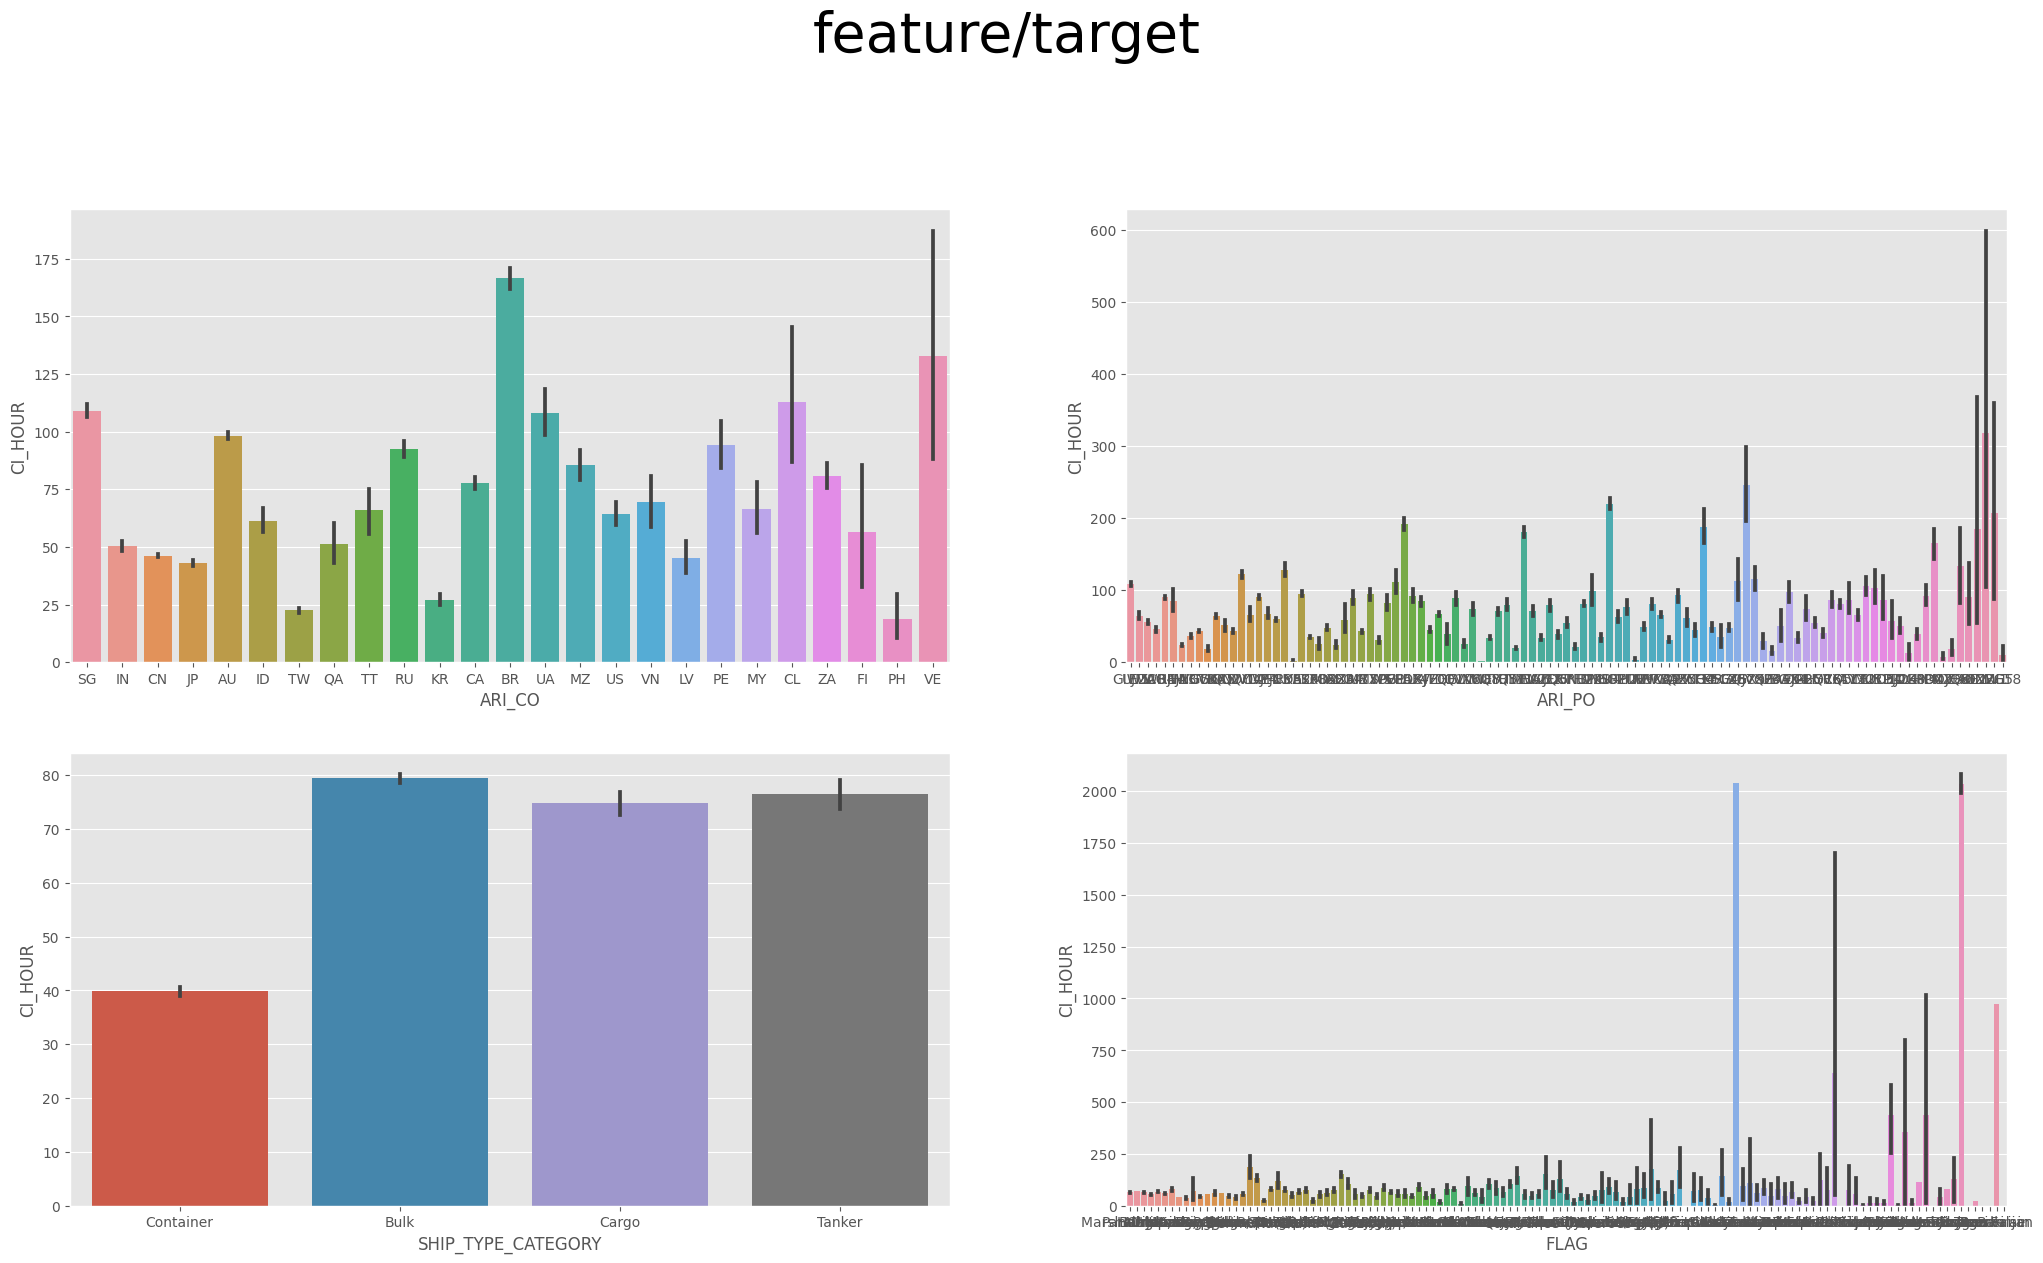

In [16]:
plt.figure(figsize=(25,20))
plt.suptitle('feature/target', fontsize=40)

i = 0
for col_name in ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'FLAG']:
    print(f'{i + 1}th col')
    plt.subplot(3, 2, i + 1)
    i += 1
    sns.barplot(data = train, x = col_name, y = 'CI_HOUR')

plt.show()

categorical feature와 target 간의 비교 결과 :  

SHIP_TYPE_CATEGORY, year, weekday one hot encoding 변환!

이런 식으로 여러가지 그래프를 그려가며, 데이터에 대한 인사이트를 얻습니다!

# 전처리

**결측치 탐색 결과**  
U_WIND, V_WIND, AIR_TEMPERATURE, BN의 결측치가 많음  
나머지 결측은 drop할 예정

**수치 데이터 분포 탐색 결과**  
수치 데이터 분포 탐색 결과 : DIST, DEADWEIGHT, GT, BDI_ADJ

**categorical feature와 target 간의 비교 결과**   
SHIP_TYPE_CATEGORY 를 기준으로 데이터를 분리해서 학습해보자

#### 결측치 처리

U_WIND, V_WIND, AIR_TEMPERATURE, BN의 결측치가 많음  
나머지 결측은 drop할 예정

In [9]:
for df in [train, test]: # train, test 모두 진행
    df.U_WIND = df.U_WIND.interpolate()
    df.V_WIND = df.V_WIND.interpolate()
    df.AIR_TEMPERATURE = df.AIR_TEMPERATURE.interpolate()
    df.BN = df.BN.interpolate()
    df = df.dropna()
    df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391935 entries, 3 to 391938
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              391935 non-null  object 
 1   ARI_PO              391935 non-null  object 
 2   SHIP_TYPE_CATEGORY  391935 non-null  object 
 3   DIST                391935 non-null  float64
 4   ID                  391935 non-null  object 
 5   BREADTH             391935 non-null  float64
 6   BUILT               391935 non-null  int64  
 7   DEADWEIGHT          391935 non-null  int64  
 8   DEPTH               391935 non-null  float64
 9   DRAUGHT             391935 non-null  float64
 10  GT                  391935 non-null  int64  
 11  LENGTH              391935 non-null  float64
 12  SHIPMANAGER         391935 non-null  object 
 13  FLAG                391935 non-null  object 
 14  U_WIND              391935 non-null  float64
 15  V_WIND              391935 non-nul

#### 왜도 처리

수치 데이터 분포 탐색 결과 : DIST, DEADWEIGHT, GT, BDI_ADJ

In [18]:
# for xstr in ['DIST', 'DEADWEIGHT', 'GT']:
#     print(xstr, "Scew :", train[xstr].skew())

DIST Scew : 2.482925677083371
DEADWEIGHT Scew : 1.5715726049888608
GT Scew : 1.4989979859353066


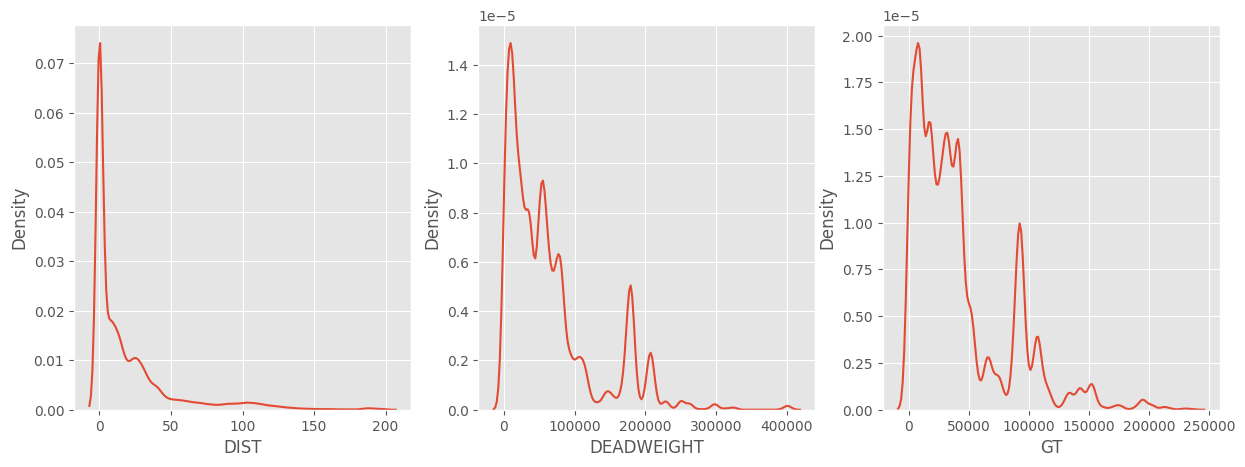

In [19]:
# plt.figure(figsize = (20, 5))
# i = 0
# for xstr in ['DIST', 'DEADWEIGHT', 'GT']:
#     plt.subplot(1, 4, i + 1)
#     i += 1
#     sns.kdeplot(train[xstr])
# plt.show()

In [20]:
# # log 변환
# for xstr in ['DIST', 'DEADWEIGHT', 'GT']:
#     train[xstr] = np.log1p(train[xstr])
#     test[xstr] = np.log1p(test[xstr]) # Test 데이터도 함께 전처리

In [21]:
# for xstr in ['DIST', 'DEADWEIGHT', 'GT']:
#     print(xstr, "Skew :", train[xstr].skew())

DIST Skew : 0.17155987351064633
DEADWEIGHT Skew : -0.7811549855892388
GT Skew : -1.088456775151332


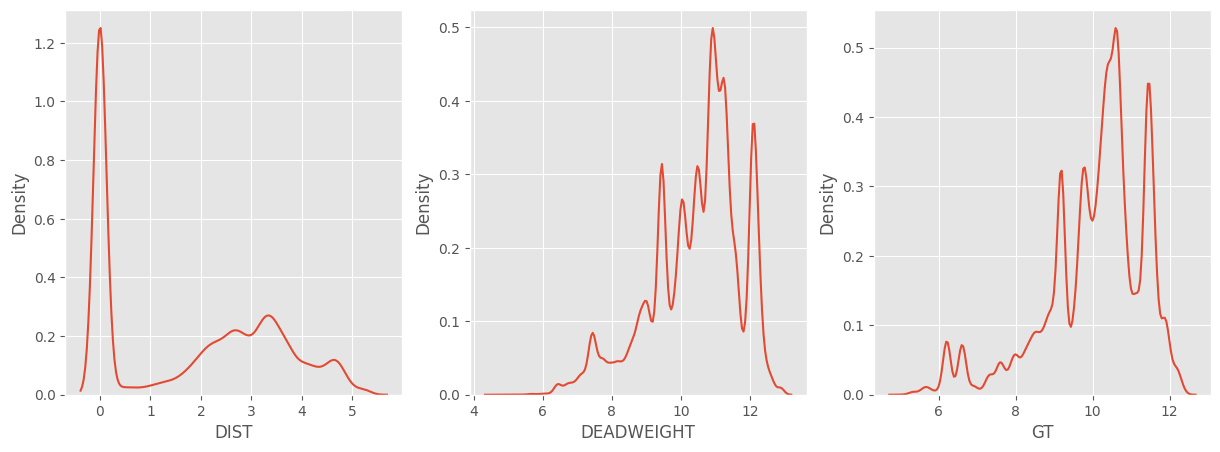

In [22]:
# plt.figure(figsize = (20, 5))
# i = 0
# for xstr in ['DIST', 'DEADWEIGHT', 'GT']:
#     plt.subplot(1, 4, i + 1)
#     i += 1
#     sns.kdeplot(train[xstr])
# plt.show()

#### categorical feature 처리

SHIP_TYPE_CATEGORY, year, weekday one hot encoding 변환!

In [10]:
print(train.shape, test.shape)

(391939, 27) (220491, 26)


In [11]:
import bisect
from sklearn.preprocessing import LabelEncoder

# SHIP_TYPE_CATEGORY 을 제외하고 labelEncoding
# Categorical 컬럼 인코딩 # train, test 모두 진행
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

Encoding features: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


In [12]:
train = train.drop(columns = 'ID')
test = test.drop(columns = 'ID')

One-hot encoding

In [13]:
train = pd.get_dummies(train)

In [14]:
test = pd.get_dummies(test)

In [15]:
print(train.columns, test.columns)

Index(['ARI_CO', 'ARI_PO', 'DIST', 'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH',
       'DRAUGHT', 'GT', 'LENGTH', 'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND',
       'AIR_TEMPERATURE', 'BN', 'ATA_LT', 'PORT_SIZE', 'CI_HOUR', 'year',
       'month', 'day', 'hour', 'minute', 'weekday', 'SHIP_TYPE_CATEGORY_Bulk',
       'SHIP_TYPE_CATEGORY_Cargo', 'SHIP_TYPE_CATEGORY_Container',
       'SHIP_TYPE_CATEGORY_Tanker'],
      dtype='object') Index(['ARI_CO', 'ARI_PO', 'DIST', 'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH',
       'DRAUGHT', 'GT', 'LENGTH', 'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND',
       'AIR_TEMPERATURE', 'BN', 'ATA_LT', 'PORT_SIZE', 'year', 'month', 'day',
       'hour', 'minute', 'weekday', 'SHIP_TYPE_CATEGORY_Bulk',
       'SHIP_TYPE_CATEGORY_Cargo', 'SHIP_TYPE_CATEGORY_Container',
       'SHIP_TYPE_CATEGORY_Tanker'],
      dtype='object')


In [16]:
train = pd.concat([train, pd.get_dummies(train.weekday)], axis = 1)
train = train.drop(columns = 'weekday')

In [17]:
train['not_sat'] = train[0] + train[1] + train[2] + train[3] + train[4] + train[6]
train['sat'] = train[5]
train = train.drop(columns = [0, 1, 2, 3, 4, 5, 6])

In [18]:
test = pd.concat([test, pd.get_dummies(test.weekday)], axis = 1)
test = test.drop(columns = 'weekday')

In [19]:
test['not_sat'] = test[0] + test[1] + test[2] + test[3] + test[4] + test[6]
test['sat'] = test[5]
test = test.drop(columns = [0, 1, 2, 3, 4, 5, 6])

In [20]:
train = pd.concat([train, pd.get_dummies(train.year)], axis = 1)
train = train.drop(columns = 'year')
test = pd.concat([test, pd.get_dummies(test.year)], axis = 1)
test = test.drop(columns = 'year')

In [21]:
train['not_2014'] = train[2015] + train[2016] + train[2017] + train[2018] + train[2019] + train[2020] + train[2021] + train[2022] + train[2023]
train = train.drop(columns = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

In [22]:
test['not_2014'] = test[2015] + test[2016] + test[2017] + test[2018] + test[2019] + test[2020] + test[2021] + test[2022] + test[2023]
test = test.drop(columns = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

In [23]:
train = train.drop(columns = ['not_sat', 'not_2014'])
test = test.drop(columns = ['not_sat', 'not_2014'])

In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220491 entries, 0 to 220490
Data columns (total 28 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   ARI_CO                        220491 non-null  int64  
 1   ARI_PO                        220491 non-null  int64  
 2   DIST                          220491 non-null  float64
 3   BREADTH                       220491 non-null  float64
 4   BUILT                         220491 non-null  int64  
 5   DEADWEIGHT                    220491 non-null  int64  
 6   DEPTH                         220491 non-null  float64
 7   DRAUGHT                       220491 non-null  float64
 8   GT                            220491 non-null  int64  
 9   LENGTH                        220491 non-null  float64
 10  SHIPMANAGER                   220491 non-null  int64  
 11  FLAG                          220491 non-null  int64  
 12  U_WIND                        220491 non-nul

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 29 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   ARI_CO                        391939 non-null  int64  
 1   ARI_PO                        391939 non-null  int64  
 2   DIST                          391939 non-null  float64
 3   BREADTH                       391938 non-null  float64
 4   BUILT                         391939 non-null  int64  
 5   DEADWEIGHT                    391939 non-null  int64  
 6   DEPTH                         391938 non-null  float64
 7   DRAUGHT                       391938 non-null  float64
 8   GT                            391939 non-null  int64  
 9   LENGTH                        391938 non-null  float64
 10  SHIPMANAGER                   391939 non-null  int64  
 11  FLAG                          391939 non-null  int64  
 12  U_WIND                        391936 non-nul

In [38]:
print(train.shape, test.shape)

(391939, 29) (220491, 28)


#### 다중공선성 처리

Categorical feature encoding 후 살펴보기

<ipython-input-106-e8f0dcb90d8b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = train.corr()


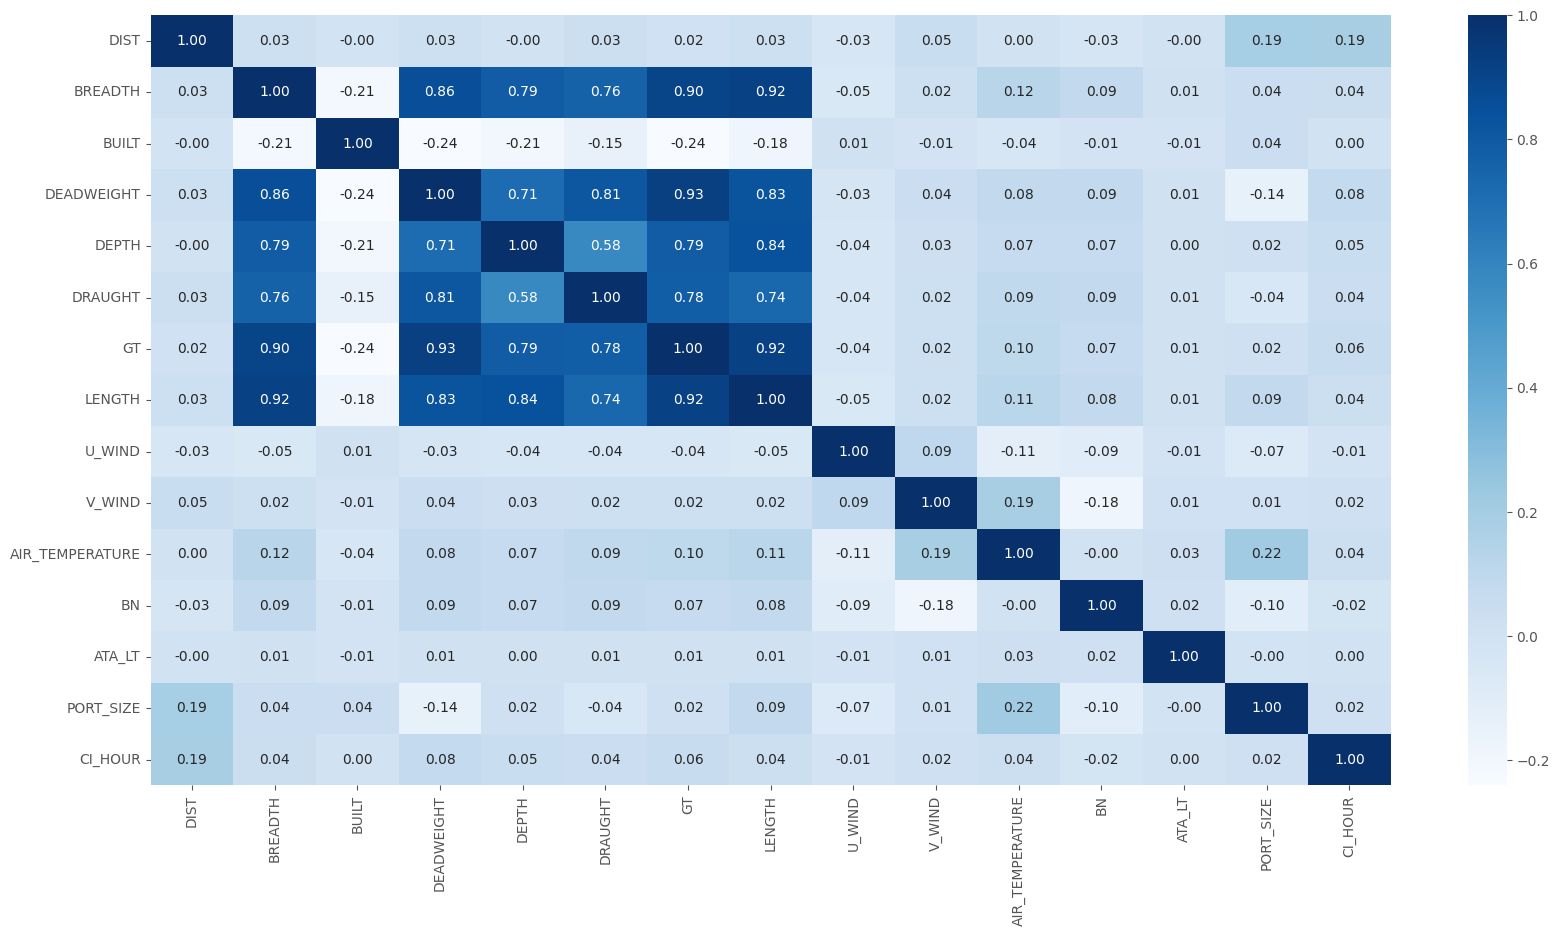

In [106]:
corr_df = train.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr_df, annot = True, fmt = '.2f', cmap = 'Blues')
plt.savefig('pre_heat.png')

상관계수 0.8 이상인 페어  
상관관수가 큰 경우 타겟과 상관관계가 상대적으로 낮은 피처를 삭제   
BREDTH(0.04) - DEAD(0.05), GT(0.03), LENGTH -->>>> BREADTH, GT 제거  
DEAD(0.05) - BREADTH, DEPTH(0.05), GT, LENGTH(0.04) -->>>>> LENGTH 제거  
최종적으로 ['BREADTH', 'DEPTH', 'LENGTH', 'GT'] 삭제

In [107]:
# del_corr_cols = ['BREADTH', 'DEPTH', 'LENGTH', 'GT', 'DRAUGHT', 'not_2014', 'not_sat']

# train_drop = train.drop(columns = del_corr_cols)
# test_drop = test.drop(columns = del_corr_cols)

In [108]:
# print(train_drop.shape, test_drop.shape)

(391939, 17) (220491, 16)


<ipython-input-110-8b318f763338>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = train_drop.corr()


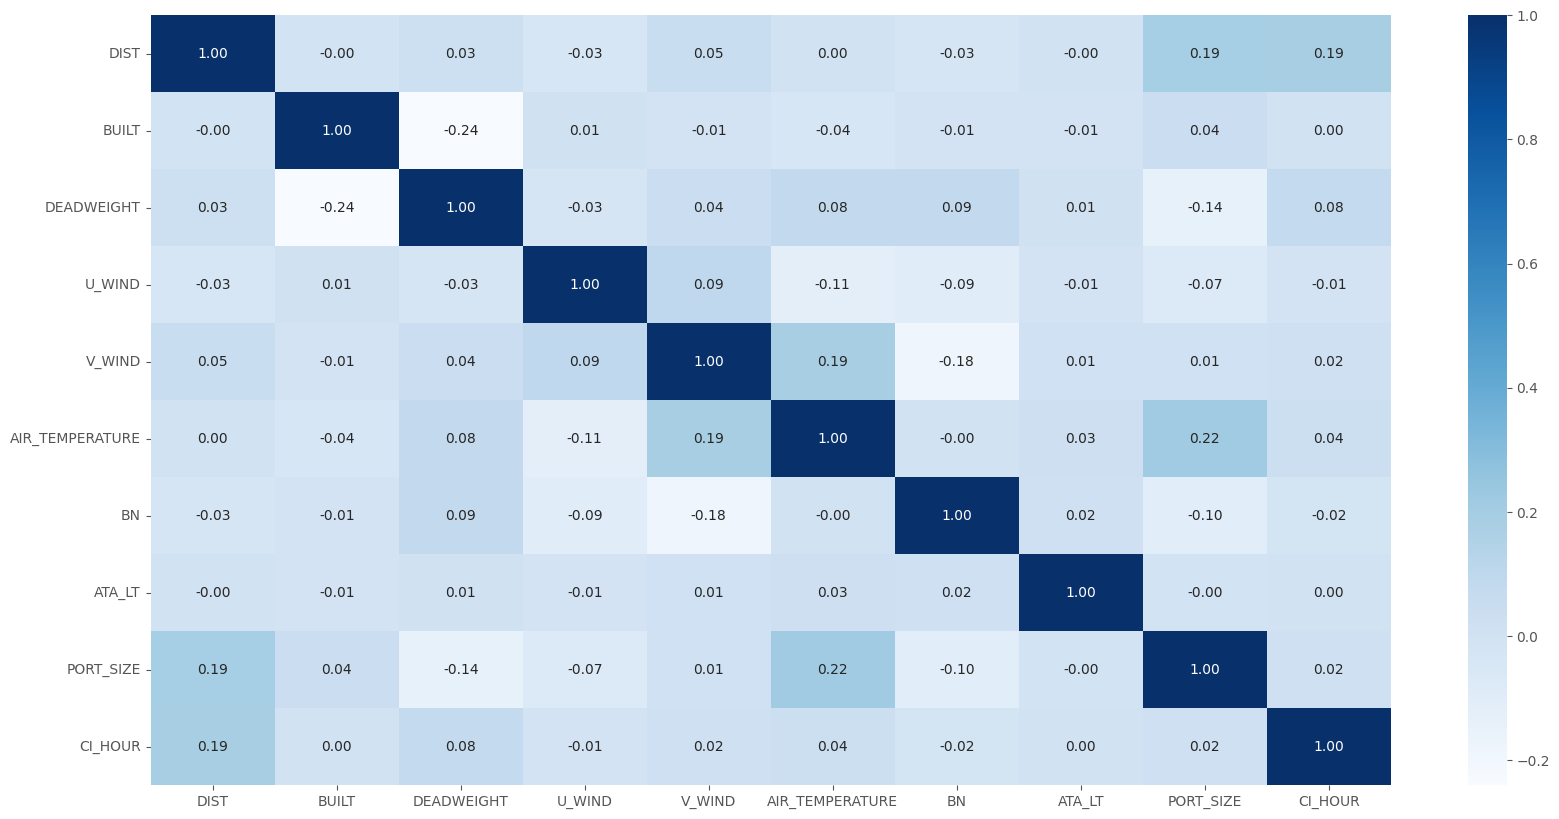

In [110]:
# corr_df = train_drop.corr()
# plt.figure(figsize=(20,10))
# sns.heatmap(corr_df, annot = True, fmt = '.2f', cmap = 'Blues')
# plt.savefig('after_heat_png')

#### 이상치 처리

In [183]:
# train_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   ARI_CO                        391939 non-null  int64  
 1   ARI_PO                        391939 non-null  int64  
 2   DIST                          391939 non-null  float64
 3   BUILT                         391939 non-null  int64  
 4   DEADWEIGHT                    391939 non-null  float64
 5   SHIPMANAGER                   391939 non-null  int64  
 6   FLAG                          391939 non-null  int64  
 7   U_WIND                        391936 non-null  float64
 8   V_WIND                        391936 non-null  float64
 9   AIR_TEMPERATURE               391936 non-null  float64
 10  BN                            391936 non-null  float64
 11  ATA_LT                        391939 non-null  int64  
 12  PORT_SIZE                     391939 non-nul

ARI_CO                Axes(0.125,0.786098;0.0945122x0.0939024)
ARI_PO             Axes(0.238415,0.786098;0.0945122x0.0939024)
DIST               Axes(0.351829,0.786098;0.0945122x0.0939024)
BUILT              Axes(0.465244,0.786098;0.0945122x0.0939024)
DEADWEIGHT         Axes(0.578659,0.786098;0.0945122x0.0939024)
SHIPMANAGER        Axes(0.692073,0.786098;0.0945122x0.0939024)
FLAG               Axes(0.805488,0.786098;0.0945122x0.0939024)
U_WIND                Axes(0.125,0.673415;0.0945122x0.0939024)
V_WIND             Axes(0.238415,0.673415;0.0945122x0.0939024)
AIR_TEMPERATURE    Axes(0.351829,0.673415;0.0945122x0.0939024)
BN                 Axes(0.465244,0.673415;0.0945122x0.0939024)
ATA_LT             Axes(0.578659,0.673415;0.0945122x0.0939024)
PORT_SIZE          Axes(0.692073,0.673415;0.0945122x0.0939024)
dtype: object

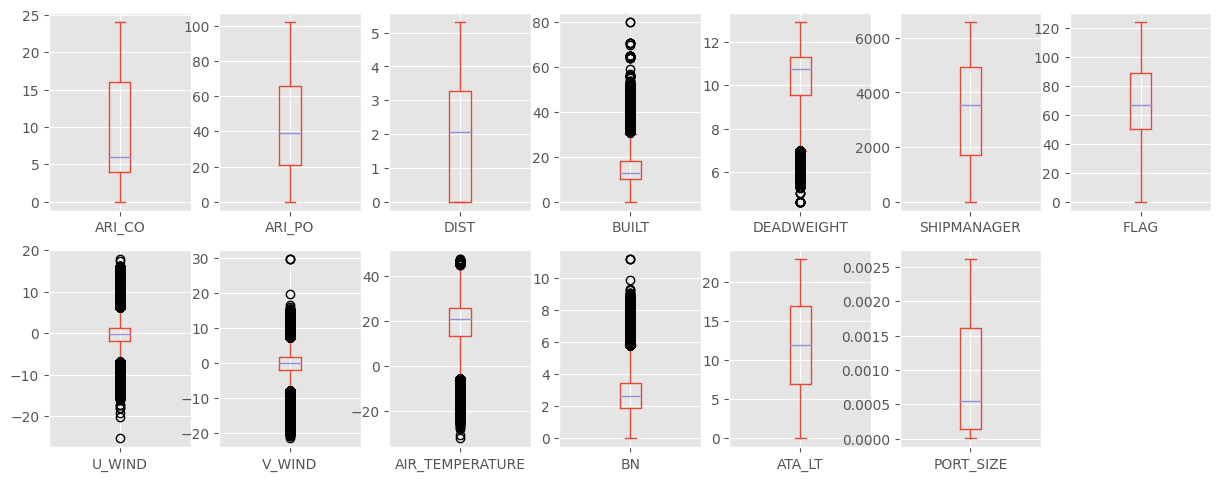

In [184]:
# train_drop.iloc[:,:13].plot(kind='box', subplots=True,layout=(7, 7), figsize=(15, 21))

In [185]:
# def outliers_iqr(data):
#     q1, q3 = np.percentile(data, [25, 75])
#     iqr = q3 - q1
#     lower_bound = q1 - (1.5*iqr)
#     upper_bound = q3 + (1.5*iqr)

#     return np.where((data > upper_bound) | (data < lower_bound))

In [186]:
train_drop[['BUILT', 'DEADWEIGHT', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']].describe()

,BUILT,DEADWEIGHT,U_WIND,V_WIND,AIR_TEMPERATURE,BN
count,391939.000000,391939.000000,391936.000000,391936.000000,391936.000000,391936.000000
mean,14.747989,10.451837,-0.287775,-0.261583,18.868504,2.706496
std,7.043988,1.290639,3.032565,3.369256,8.762110,1.252228
min,0.000000,4.615121,-25.330000,-21.450000,-32.200000,0.000000
25%,10.000000,9.568085,-1.973333,-2.070000,13.200000,1.896132
50%,13.000000,10.766399,-0.200000,0.000000,20.750000,2.639531
75%,18.000000,11.308371,1.386000,1.760000,25.800000,3.457522
max,80.000000,12.909173,17.910000,29.690000,47.600000,11.179660


In [187]:
# outlier_cols = ['BUILT', 'DEADWEIGHT', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']
# for col_name in tqdm(outlier_cols):
#     outlier_index = outliers_iqr(train_drop[col_name])[0]
#     train_drop.loc[outlier_index, col_name] = train_drop[col_name].mean()

100%|██████████| 6/6 [00:00<00:00, 70.44it/s]


In [188]:
# train_drop[['BUILT', 'DEADWEIGHT', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']].describe()

,BUILT,DEADWEIGHT,U_WIND,V_WIND,AIR_TEMPERATURE,BN
count,391939.000000,391939.000000,391936.000000,391936.000000,391936.000000,391936.000000
mean,14.244727,10.493457,-0.287775,-0.261583,18.868504,2.706496
std,6.232729,1.225347,3.032565,3.369256,8.762110,1.252228
min,0.000000,6.966967,-25.330000,-21.450000,-32.200000,0.000000
25%,10.000000,9.680406,-1.973333,-2.070000,13.200000,1.896132
50%,13.000000,10.766399,-0.200000,0.000000,20.750000,2.639531
75%,18.000000,11.308371,1.386000,1.760000,25.800000,3.457522
max,30.000000,12.909173,17.910000,29.690000,47.600000,11.179660


ARI_CO                Axes(0.125,0.786098;0.0945122x0.0939024)
ARI_PO             Axes(0.238415,0.786098;0.0945122x0.0939024)
DIST               Axes(0.351829,0.786098;0.0945122x0.0939024)
BUILT              Axes(0.465244,0.786098;0.0945122x0.0939024)
DEADWEIGHT         Axes(0.578659,0.786098;0.0945122x0.0939024)
SHIPMANAGER        Axes(0.692073,0.786098;0.0945122x0.0939024)
FLAG               Axes(0.805488,0.786098;0.0945122x0.0939024)
U_WIND                Axes(0.125,0.673415;0.0945122x0.0939024)
V_WIND             Axes(0.238415,0.673415;0.0945122x0.0939024)
AIR_TEMPERATURE    Axes(0.351829,0.673415;0.0945122x0.0939024)
BN                 Axes(0.465244,0.673415;0.0945122x0.0939024)
ATA_LT             Axes(0.578659,0.673415;0.0945122x0.0939024)
PORT_SIZE          Axes(0.692073,0.673415;0.0945122x0.0939024)
dtype: object

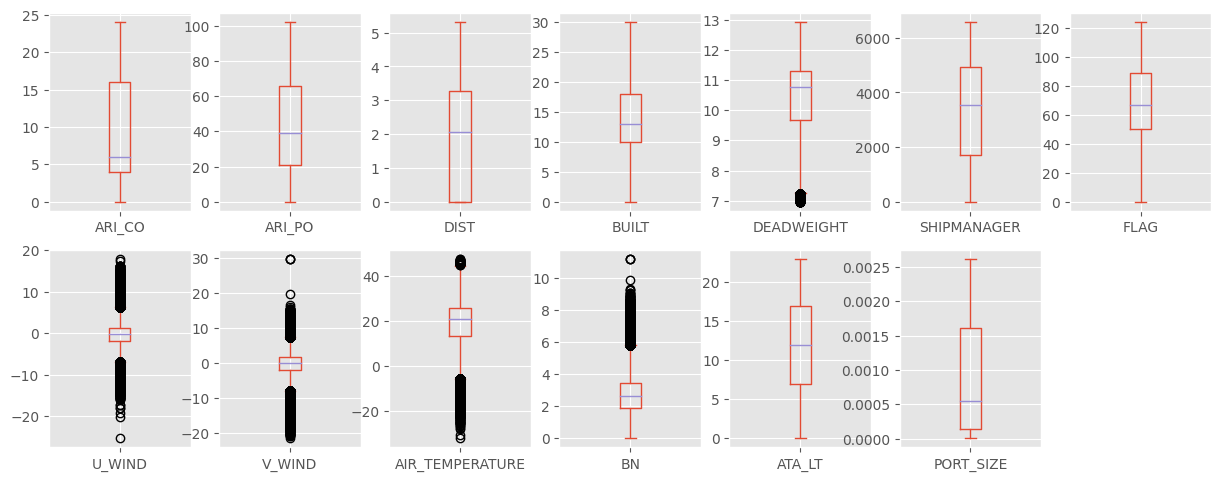

In [189]:
# train_drop.iloc[:,:13].plot(kind='box', subplots=True,layout=(7,7), figsize=(15, 21))

In [190]:
# # test데이터도 아웃라이어 처리
# outlier_cols = ['BUILT', 'DEADWEIGHT', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']
# for col_name in tqdm(outlier_cols):
#     outlier_index = outliers_iqr(test_drop[col_name])[0]
#     test_drop.loc[outlier_index, col_name] = test_drop[col_name].mean()

100%|██████████| 6/6 [00:00<00:00, 117.35it/s]


# 학습 데이터 분할 및 간단한 학습

In [26]:
print(train.shape, test.shape)

(391939, 29) (220491, 28)


In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 29 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   ARI_CO                        391939 non-null  int64  
 1   ARI_PO                        391939 non-null  int64  
 2   DIST                          391939 non-null  float64
 3   BREADTH                       391938 non-null  float64
 4   BUILT                         391939 non-null  int64  
 5   DEADWEIGHT                    391939 non-null  int64  
 6   DEPTH                         391938 non-null  float64
 7   DRAUGHT                       391938 non-null  float64
 8   GT                            391939 non-null  int64  
 9   LENGTH                        391938 non-null  float64
 10  SHIPMANAGER                   391939 non-null  int64  
 11  FLAG                          391939 non-null  int64  
 12  U_WIND                        391936 non-nul

In [28]:
# 첫번째 테스트용으로 사용하고, 실제 학습시에는 K-Fold CV를 사용합니다.
from sklearn.model_selection import train_test_split

X = train.drop(columns = 'CI_HOUR')
y = train.CI_HOUR

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [29]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(274357, 28) (274357,) (117582, 28) (117582,)


In [30]:
from sklearn.metrics import mean_absolute_error
evaluation_metric = mean_absolute_error

In [31]:
# 학습 데이터 log 왜도 처리
y_train = np.log1p(y_train)

In [32]:
param_grid = {'num_leaves': 128, 'max_depth': 10, 'learning_rate': 0.2
          , 'n_estimators': 500, 'min_child_samples': 13, 'colsample_bytree': 0.6975399773068238}
model = LGBMRegressor(**param_grid, n_jobs = -1, random_state = 42)

print("\nFitting LightGBM...")
model.fit(X_train, y_train)

print("Prediction")
# Train score
pred_train = model.predict(X_train)
pred_train = np.exp(pred_train)-1 # train 성능 확인을 위한 log 벗기기
pred_train = np.where(pred_train < 0, 0, pred_train)

# Validation Score
pred_val = model.predict(X_val)
pred_val = np.exp(pred_val)-1 # log 벗기기
pred_val = np.where(pred_val < 0, 0, pred_val)

train_score = evaluation_metric(np.exp(y_train)-1, pred_train)
# train_score = evaluation_metric(y_train, pred_train)
val_score = evaluation_metric(y_val, pred_val)

print("Train Score : %.4f" % train_score)
print("Validation Score : %.4f" % val_score)


Fitting LightGBM...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 274357, number of used features: 28
[LightGBM] [Info] Start training from score 2.165834
Prediction
Train Score : 35.6096
Validation Score : 45.4368


### Feature Selection

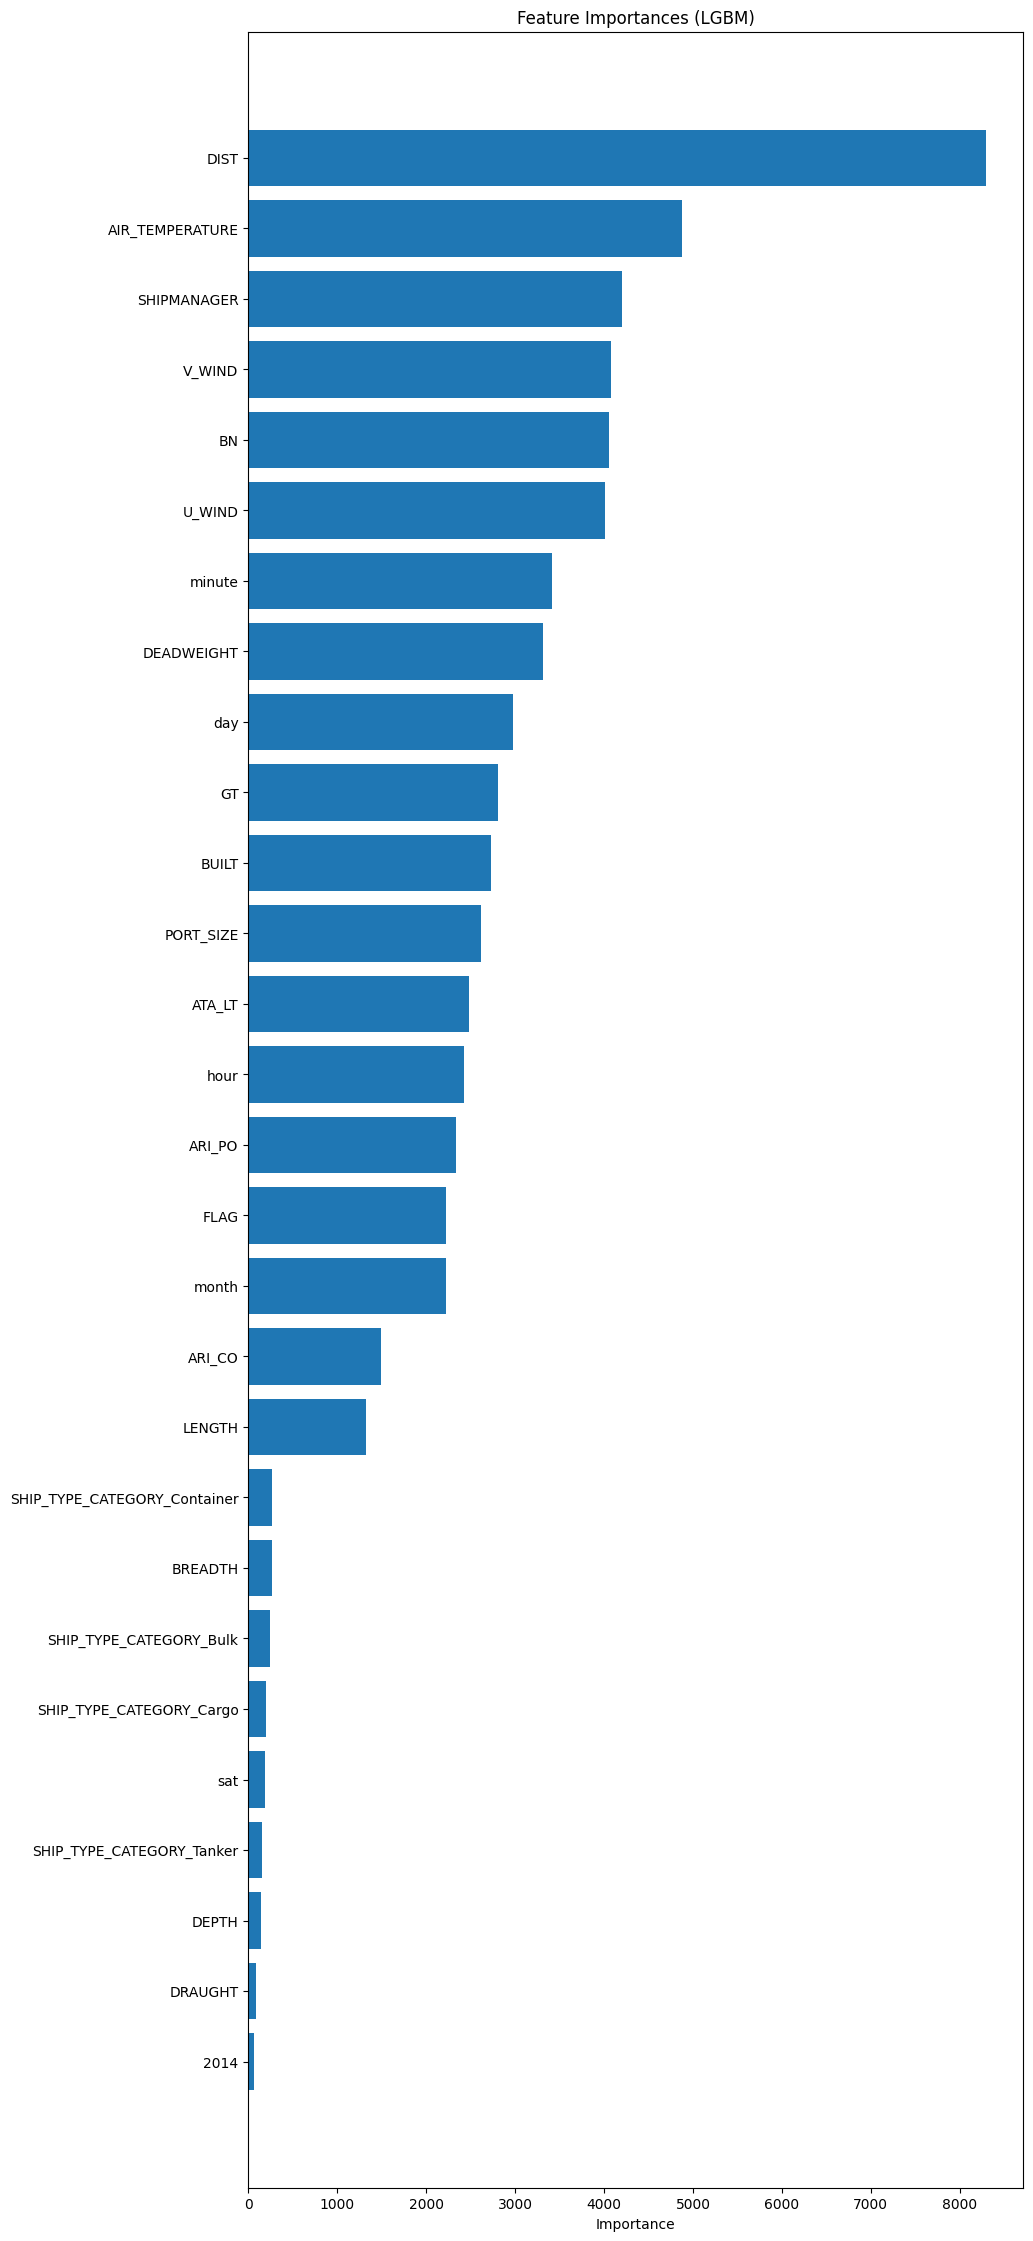

In [33]:
feature_importances = model.feature_importances_
sorted_idx = feature_importances.argsort()

plt.figure(figsize=(10, len(X_train.columns)))
plt.title(f"Feature Importances ({'LGBM'})")
plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
plt.xlabel('Importance')
plt.show()

In [34]:
feature_importances = pd.DataFrame({'Col_name' : X_train.columns,'Importance' : feature_importances})
feature_importances = feature_importances.sort_values(by = 'Importance', ascending = False)

In [35]:
feature_importances.Col_name.values

array(['DIST', 'AIR_TEMPERATURE', 'SHIPMANAGER', 'V_WIND', 'BN', 'U_WIND',
       'minute', 'DEADWEIGHT', 'day', 'GT', 'BUILT', 'PORT_SIZE',
       'ATA_LT', 'hour', 'ARI_PO', 'FLAG', 'month', 'ARI_CO', 'LENGTH',
       'SHIP_TYPE_CATEGORY_Container', 'BREADTH',
       'SHIP_TYPE_CATEGORY_Bulk', 'SHIP_TYPE_CATEGORY_Cargo', 'sat',
       'SHIP_TYPE_CATEGORY_Tanker', 'DEPTH', 'DRAUGHT', 2014],
      dtype=object)

In [36]:
feature_selection = feature_importances.Col_name.values[:19]
category_feat = np.array(['SHIP_TYPE_CATEGORY_Container', 'SHIP_TYPE_CATEGORY_Bulk', 'SHIP_TYPE_CATEGORY_Cargo',
                            'sat', 'SHIP_TYPE_CATEGORY_Tanker', 'DRAUGHT', 2014], dtype = 'object') # 6 고정
feature_selection = np.concatenate([feature_selection, category_feat])

train_reduced = train[feature_selection]
test_reduced = test[feature_selection]

In [37]:
len(train.drop(columns = 'CI_HOUR').columns)

28

In [38]:
print(feature_selection, len(feature_selection))

['DIST' 'AIR_TEMPERATURE' 'SHIPMANAGER' 'V_WIND' 'BN' 'U_WIND' 'minute'
 'DEADWEIGHT' 'day' 'GT' 'BUILT' 'PORT_SIZE' 'ATA_LT' 'hour' 'ARI_PO'
 'FLAG' 'month' 'ARI_CO' 'LENGTH' 'SHIP_TYPE_CATEGORY_Container'
 'SHIP_TYPE_CATEGORY_Bulk' 'SHIP_TYPE_CATEGORY_Cargo' 'sat'
 'SHIP_TYPE_CATEGORY_Tanker' 'DRAUGHT' 2014] 26


# Parameter Tuning

#### Parameter Tuning (LGBM)

In [121]:
train_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   DIST                          391939 non-null  float64
 1   AIR_TEMPERATURE               391936 non-null  float64
 2   SHIPMANAGER                   391939 non-null  int64  
 3   V_WIND                        391936 non-null  float64
 4   BN                            391936 non-null  float64
 5   U_WIND                        391936 non-null  float64
 6   minute                        391939 non-null  int64  
 7   DEADWEIGHT                    391939 non-null  int64  
 8   day                           391939 non-null  int64  
 9   GT                            391939 non-null  int64  
 10  BUILT                         391939 non-null  int64  
 11  PORT_SIZE                     391939 non-null  float64
 12  ATA_LT                        391939 non-nul

In [127]:
X_train = train_reduced
y_train = train.CI_HOUR
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)

In [128]:
# 학습 데이터 log 왜도 처리
y_train = np.log1p(y_train)

In [129]:
params = {'num_leaves': 128, 'max_depth': 10, 'learning_rate': 0.3
          , 'n_estimators': 50, 'min_child_samples': 13, 'colsample_bytree': 0.6975399773068238}
model = LGBMRegressor(**params, n_jobs = -1, random_state = 42)
model.fit(X_train, y_train)

train_pred = model.predict(X_train)
train_pred = np.exp(train_pred)-1 # log 벗기기
train_pred = np.where(train_pred < 0, 0, train_pred)

test_pred = model.predict(X_val)
test_pred = np.exp(test_pred)-1 # log 벗기기
test_pred = np.where(test_pred < 0, 0, test_pred)

print('Train MAE: ', mean_absolute_error(train_pred, np.exp(y_train)-1))
print('Test MAE: ', mean_absolute_error(test_pred, y_val))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2637
[LightGBM] [Info] Number of data points in the train set: 274357, number of used features: 26
[LightGBM] [Info] Start training from score 2.165834
Train MAE:  44.35915464521099
Test MAE:  45.4129246886682


In [144]:
params = {'num_leaves': 128, 'max_depth': 10, 'learning_rate': 0.07
          , 'n_estimators': 700, 'min_child_samples': 13, 'colsample_bytree': 0.6975399773068238}
lgbm = LGBMRegressor(**params, n_jobs = -1, random_state = 42)

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
scores = []

for train_idx, val_idx in tqdm(kf.split(train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = train_reduced.iloc[train_idx], train_reduced.iloc[val_idx]
    y_t, y_val = train.CI_HOUR.iloc[train_idx], train.CI_HOUR.iloc[val_idx]
    # 학습 데이터 log 왜도 처리
    y_t = np.log1p(y_t)

    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)
    val_pred = np.exp(val_pred)-1 # log 벗기기
    val_pred = np.where(val_pred < 0, 0, val_pred)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2633
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 26
[LightGBM] [Info] Start training from score 2.165122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Processing folds:  20%|██        | 1/5 [00:12<00:50, 12.66s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2639
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 26
[LightGBM] [Info] Start training from score 2.161757


Processing folds:  40%|████      | 2/5 [00:21<00:31, 10.63s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.114560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2635
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 26
[LightGBM] [Info] Start training from score 2.162281


Processing folds:  60%|██████    | 3/5 [00:34<00:22, 11.44s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2643
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 26
[LightGBM] [Info] Start training from score 2.163313


Processing folds:  80%|████████  | 4/5 [00:46<00:11, 11.93s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2636
[LightGBM] [Info] Number of data points in the train set: 313552, number of used features: 26
[LightGBM] [Info] Start training from score 2.164107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Processing folds: 100%|██████████| 5/5 [00:58<00:00, 11.76s/it]

Validation : MAE scores for each fold: [44.85109573860521, 46.30119797997296, 45.983523281439616, 45.421872022293776, 45.072553913125645]
Validation : MAE: 45.52604858708744


In [145]:
lgbm.get_params

<bound method LGBMModel.get_params of LGBMRegressor(colsample_bytree=0.6975399773068238, learning_rate=0.07,
              max_depth=10, min_child_samples=13, n_estimators=700, n_jobs=-1,
              num_leaves=128, random_state=42)>

params = {'num_leaves': 128, 'max_depth': 10, 'learning_rate': 0.07
          , 'n_estimators': 700, 'min_child_samples': 13, 'colsample_bytree': 0.6975399773068238}  
feature 27  
MAE: 45.52603452075389

#### Parameter Tuning (CATBoost)

In [57]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 17.4 MB/s eta 0:00:00


In [58]:
from catboost import CatBoostRegressor

In [148]:
train_reduced.columns

Index([                        'DIST',              'AIR_TEMPERATURE',
                        'SHIPMANAGER',                       'V_WIND',
                                 'BN',                       'U_WIND',
                             'minute',                   'DEADWEIGHT',
                                'day',                           'GT',
                              'BUILT',                    'PORT_SIZE',
                             'ATA_LT',                         'hour',
                             'ARI_PO',                         'FLAG',
                              'month',                       'ARI_CO',
                             'LENGTH', 'SHIP_TYPE_CATEGORY_Container',
            'SHIP_TYPE_CATEGORY_Bulk',     'SHIP_TYPE_CATEGORY_Cargo',
                                'sat',    'SHIP_TYPE_CATEGORY_Tanker',
                            'DRAUGHT',                           2014],
      dtype='object')

In [149]:
X_train = train_reduced
y_train = train.CI_HOUR
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)

In [150]:
# 학습 데이터 log 왜도 처리
y_train = np.log1p(y_train)

In [178]:
params = {'depth': 10, 'learning_rate': 0.08, 'silent' : True
          , 'iterations': 1000, 'rsm' : 0.5, 'loss_function' : 'MAE', 'random_seed' : 42}
model = CatBoostRegressor(**params)

model.fit(X_train, y_train)

train_pred = model.predict(X_train)
train_pred = np.exp(train_pred)-1 # log 벗기기
train_pred = np.where(train_pred < 0, 0, train_pred)

test_pred = model.predict(X_val)
test_pred = np.exp(test_pred)-1 # log 벗기기
test_pred = np.where(test_pred < 0, 0, test_pred)

print('Train MAE: ', mean_absolute_error(train_pred, np.exp(y_train)-1))
print('Test MAE: ', mean_absolute_error(test_pred, y_val))

Train MAE:  41.67368683547985
Test MAE:  45.61113782963247


In [179]:
params = {'depth': 10, 'learning_rate': 0.08, 'silent' : True
          , 'iterations': 1000, 'rsm' : 0.5, 'loss_function' : 'MAE', 'random_seed' : 42}
cb = CatBoostRegressor(**params)

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
scores = []

for train_idx, val_idx in tqdm(kf.split(train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = train_reduced.iloc[train_idx], train_reduced.iloc[val_idx]
    y_t, y_val = train.CI_HOUR.iloc[train_idx], train.CI_HOUR.iloc[val_idx]
    # 학습 데이터 log 왜도 처리
    y_t = np.log1p(y_t)

    # 두 모델 모두 학습
    cb.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = cb.predict(X_val)
    val_pred = np.exp(val_pred)-1 # log 벗기기
    val_pred = np.where(val_pred < 0, 0, val_pred)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds: 100%|██████████| 5/5 [04:55<00:00, 59.15s/it]

Validation : MAE scores for each fold: [45.44690869319165, 46.84843764392846, 46.658068484814564, 46.06124158576169, 45.8058752549124]
Validation : MAE: 46.16410633252176


In [180]:
print(cb.get_params())

{'iterations': 1000, 'learning_rate': 0.08, 'depth': 10, 'rsm': 0.5, 'loss_function': 'MAE', 'random_seed': 42, 'silent': True}


params = {'depth': 10, 'learning_rate': 0.08, 'silent' : True
          , 'iterations': 1000, 'rsm' : 0.5, 'loss_function' : 'MAE', 'random_seed' : 42}    
feature 27  
MAE: 46.16410633252176

#### Parameter Tuning (XGBoost)

In [39]:
from xgboost import XGBRegressor

In [40]:
train_reduced.columns

Index([                        'DIST',              'AIR_TEMPERATURE',
                        'SHIPMANAGER',                       'V_WIND',
                                 'BN',                       'U_WIND',
                             'minute',                   'DEADWEIGHT',
                                'day',                           'GT',
                              'BUILT',                    'PORT_SIZE',
                             'ATA_LT',                         'hour',
                             'ARI_PO',                         'FLAG',
                              'month',                       'ARI_CO',
                             'LENGTH', 'SHIP_TYPE_CATEGORY_Container',
            'SHIP_TYPE_CATEGORY_Bulk',     'SHIP_TYPE_CATEGORY_Cargo',
                                'sat',    'SHIP_TYPE_CATEGORY_Tanker',
                            'DRAUGHT',                           2014],
      dtype='object')

In [41]:
X_train = train_reduced
y_train = train.CI_HOUR
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)

In [42]:
# 학습 데이터 log 왜도 처리
y_train = np.log1p(y_train)

In [43]:
params = {'max_depth': 10, 'learning_rate': 0.02, 'verbosity' : 0
          , 'n_estimators': 800, 'colsample_bynode' : 0.5, 'random_state' : 42}
model = XGBRegressor(**params)

model.fit(X_train, y_train)

train_pred = model.predict(X_train)
train_pred = np.exp(train_pred)-1 # log 벗기기
train_pred = np.where(train_pred < 0, 0, train_pred)

test_pred = model.predict(X_val)
test_pred = np.exp(test_pred)-1 # log 벗기기
test_pred = np.where(test_pred < 0, 0, test_pred)

print('Train MAE: ', mean_absolute_error(train_pred, np.exp(y_train)-1))
print('Test MAE: ', mean_absolute_error(test_pred, y_val))

Train MAE:  39.74978361334424
Test MAE:  44.679180379659336


In [45]:
params = {'max_depth': 10, 'learning_rate': 0.03, 'verbosity' : 0
          , 'n_estimators': 800, 'colsample_bynode' : 0.5, 'random_state' : 42}
xgb = XGBRegressor(**params)

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
scores = []

for train_idx, val_idx in tqdm(kf.split(train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = train_reduced.iloc[train_idx], train_reduced.iloc[val_idx]
    y_t, y_val = train.CI_HOUR.iloc[train_idx], train.CI_HOUR.iloc[val_idx]
    # 학습 데이터 log 왜도 처리
    y_t = np.log1p(y_t)

    # 두 모델 모두 학습
    xgb.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = xgb.predict(X_val)
    val_pred = np.exp(val_pred)-1 # log 벗기기
    val_pred = np.where(val_pred < 0, 0, val_pred)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds: 100%|██████████| 5/5 [02:23<00:00, 28.77s/it]

Validation : MAE scores for each fold: [44.5794062336102, 45.884277368687265, 45.785621285712985, 45.12305044020092, 44.80569236990783]
Validation : MAE: 45.23560953962384


params = {'max_depth': 10, 'learning_rate': 0.03, 'verbosity' : 0
          , 'n_estimators': 800, 'colsample_bynode' : 0.5, 'random_state' : 42}  
feature 27  
MAE: 45.23560953962384

# Ensemble

### LGBM, CatBoost, XGBoost

Feature importance 기준 상위 Feature N개 + categorical = 27개
Parameter and MAE
* LGBM : MAE: 45.52603452075389
```
{'num_leaves': 128, 'max_depth': 10, 'learning_rate': 0.07
, 'n_estimators': 700, 'min_child_samples': 13, 'colsample_bytree': 0.6975399773068238}
```
* CatBoost : MAE: 46.16410633252176
```
{'depth': 10, 'learning_rate': 0.08, 'silent' : True
, 'iterations': 1000, 'rsm' : 0.5, 'loss_function' : 'MAE', 'random_seed' : 42}  
```
* XGBoost : MAE: 45.23560953962384
```
{'max_depth': 10, 'learning_rate': 0.03, 'verbosity' : 0
, 'n_estimators': 800, 'colsample_bynode' : 0.5, 'random_state' : 42}
```


### 가중치 평균을 통한 앙상블

In [84]:
def get_lgbm_pred(X_train, y_train, X_test):
    print('Light GBM modeling and predict')
    params = {'num_leaves': 128, 'max_depth': 10, 'learning_rate': 0.07
            , 'n_estimators': 700, 'min_child_samples': 13, 'colsample_bytree': 0.6975399773068238}
    lgbm = LGBMRegressor(**params, n_jobs = -1, random_state = 42)

    lgbm.fit(X_train, y_train)

    lgbm_pred = lgbm.predict(X_test)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    train_pred = lgbm.predict(X_train)
    train_pred = np.where(train_pred < 0, 0, train_pred)
    mae = mean_absolute_error(train_pred, y_train)

    return lgbm_pred, mae

In [85]:
def get_cboost_pred(X_train, y_train, X_test):
    print('CatBoost modeling and predict')
    params = {'depth': 10, 'learning_rate': 0.08, 'silent' : True
            , 'iterations': 1000, 'rsm' : 0.5, 'loss_function' : 'MAE', 'random_seed' : 42}
    cboost = CatBoostRegressor(**params)

    cboost.fit(X_train, y_train)

    cboost_pred = cboost.predict(X_test)
    cboost_pred = np.where(cboost_pred < 0, 0, cboost_pred)

    train_pred = cboost.predict(X_train)
    train_pred = np.where(train_pred < 0, 0, train_pred)
    mae = mean_absolute_error(train_pred, y_train)

    return cboost_pred, mae

In [86]:
def get_xgb_pred(X_train, y_train, X_test):
    print('XGBoost modeling and predict')
    params = {'max_depth': 10, 'learning_rate': 0.03, 'verbosity' : 0
            , 'n_estimators': 800, 'colsample_bynode' : 0.5, 'random_state' : 42}
    xgb = XGBRegressor(**params)

    xgb.fit(X_train, y_train)
    xgb_pred = xgb.predict(X_test)
    xgb_pred = np.where(xgb_pred < 0, 0, xgb_pred)

    train_pred = xgb.predict(X_train)
    train_pred = np.where(train_pred < 0, 0, train_pred)
    mae = mean_absolute_error(train_pred, y_train)

    return xgb_pred, mae

In [87]:
def mean_ensemble(models, X_train, y_train, X_test):
    pred = np.zeros(shape=(X_test.shape[0],))
    total_weight = 0.0
    for model in models:
        test_pred, train_score = model(X_train, y_train, X_test)
        total_weight = total_weight + (1. / train_score)
        pred = pred + (test_pred * (1. / train_score))
    pred = pred / total_weight
    pred = np.exp(pred) - 1
    return pred

In [88]:
X_train = train_reduced
y_train = train.CI_HOUR
X_test = test_reduced

y_train = np.log1p(y_train) # target log 취하기
models = [get_lgbm_pred, get_cboost_pred, get_xgb_pred]

In [89]:
print(X_train.shape, y_train.shape, X_test.shape)

(391939, 26) (391939,) (220491, 26)


In [90]:
pred = mean_ensemble(models, X_train, y_train, X_test)
pred

Light GBM modeling and predict
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2639
[LightGBM] [Info] Number of data points in the train set: 391939, number of used features: 26
[LightGBM] [Info] Start training from score 2.163316
CatBoost modeling and predict
XGBoost modeling and predict


array([3.34810414e+00, 2.66681364e+01, 2.75090731e+01, ...,
       2.26799252e+01, 3.31363481e-02, 7.71159689e+01])

### 7. 테스트 및 제출 파일 생성

In [91]:
pred

array([3.34810414e+00, 2.66681364e+01, 2.75090731e+01, ...,
       2.26799252e+01, 3.31363481e-02, 7.71159689e+01])

In [92]:
submission = pd.read_csv(file_path + 'sample_submission.csv')
submission.CI_HOUR = pred
submission.to_csv(file_path + "submission.csv", index=False)
submission

,SAMPLE_ID,CI_HOUR
0,TEST_000000,3.348104
1,TEST_000001,26.668136
2,TEST_000002,27.509073
3,TEST_000003,65.422508
4,TEST_000004,0.000465
...,...,...
220486,TEST_220486,84.942991
220487,TEST_220487,60.782321
220488,TEST_220488,22.679925
220489,TEST_220489,0.033136
